In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [34]:
def market_ode_increase_decrease(t, y, alpha_d, alpha_s, beta_d, beta_s):
    """
    A simple system of ODEs that can capture scenarios where demand (D) may 
    increase or decrease over time (due to marketing/popularity or loss of interest), 
    and supply (S) may increase or decrease (due to availability of raw materials, 
    labor constraints, or ramp-up in production).

    Parameters:
    -----------
    t       : Time (required by solve_ivp, not used explicitly here)
    y       : Array-like, y = [D, S]
        D   : Demand
        S   : Supply
    alpha_d : Float
        Positive => intrinsic growth rate of demand (e.g., marketing success).
        Negative => intrinsic decay of demand (loss of popularity).
    alpha_s : Float
        Positive => intrinsic growth rate of supply (e.g., robust production).
        Negative => intrinsic decay of supply (raw material shortage).
    beta_d  : Float
        Cross-impact on demand due to supply. A positive value can reduce demand if supply is lacking,
        or a negative value can increase demand if supply is high (uncommon but possible).
    beta_s  : Float
        Cross-impact on supply due to demand. A positive value can reduce supply if demand is too high (e.g. rapid depletion of stock),
        or a negative value can stimulate supply if demand is high (incentivizing production).

    Returns:
    --------
    [dD_dt, dS_dt] : List of floats
        Time derivatives for demand and supply.
    """
    D, S = y

    # Intrinsic demand growth/decay
    dD_dt = alpha_d * D
    # Adjust demand based on supply availability:
    # If beta_d > 0 and supply is less than demand, it can reduce D further,
    # or if supply is greater, it might not reduce D as much (depending on how you model it).
    # Here we just do a simple coupling: - beta_d * (D - S).
    # Feel free to adjust to match desired behavior.
    dD_dt += - beta_d * (D - S)
    
    # Intrinsic supply growth/decay
    dS_dt = alpha_s * S
    # Adjust supply based on demand:
    dS_dt += - beta_s * (S - D)

    return [dD_dt, dS_dt]


In [63]:
def plot_market_ode(alpha_d, alpha_s, beta_d, beta_s, y0):
    # Time span for simulation
    T = 1000
    t_span = (0, T)
    t_eval = np.linspace(t_span[0], t_span[1], T*5)

    # Solve the ODE
    solution = solve_ivp(
        market_ode_increase_decrease, 
        t_span, 
        y0, 
        args=(alpha_d, alpha_s, beta_d, beta_s), 
        t_eval=t_eval
    )

    # Extract solution
    t_vals = solution.t
    D_vals = solution.y[0]
    S_vals = solution.y[1]

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(t_vals, D_vals, label='Demand (D)', linewidth=2)
    plt.plot(t_vals, S_vals, label='Supply (S)', linewidth=2)
    plt.title("Demand-Supply Dynamics with Increasing/Decreasing Trends")
    plt.xlabel("Time")
    plt.ylabel("Quantity")
    plt.grid(True)
    plt.legend()
    plt.show()


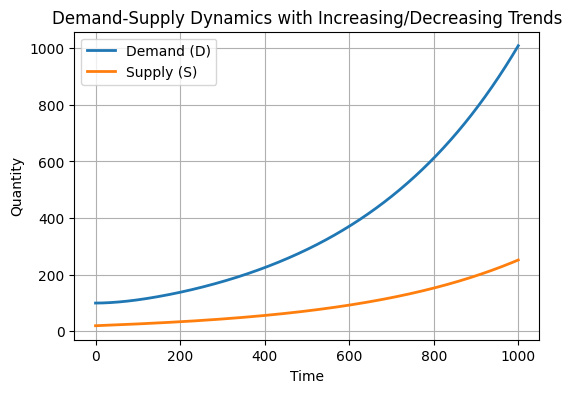

In [81]:
"""
Choose parameters to show how demand can grow and supply can shrink over time:
alpha_d = 0.02   -> Demand grows at 2% per time unit if unchecked
alpha_s = -0.01  -> Supply declines at 1% per time unit if unchecked (shortages)
beta_d  = 0.005  -> Demand is somewhat discouraged if it exceeds supply
beta_s  = 0.0005 -> Supply is somewhat depleted faster if demand is higher
"""

alpha_d = 0.04
alpha_s = 0.001
beta_d  = 0.05
beta_s  = 0.0005

# Initial values
D0 = 100  # starting demand
S0 = 20  # starting supply
y0 = [D0, S0]

plot_market_ode(alpha_d, alpha_s, beta_d, beta_s, y0)

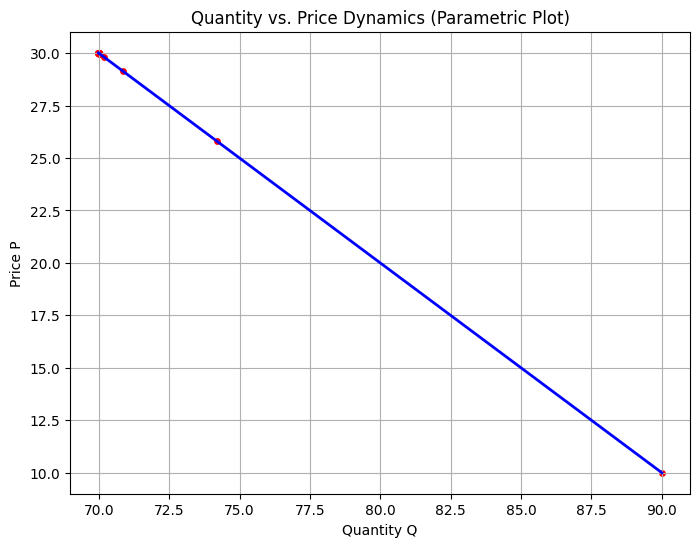

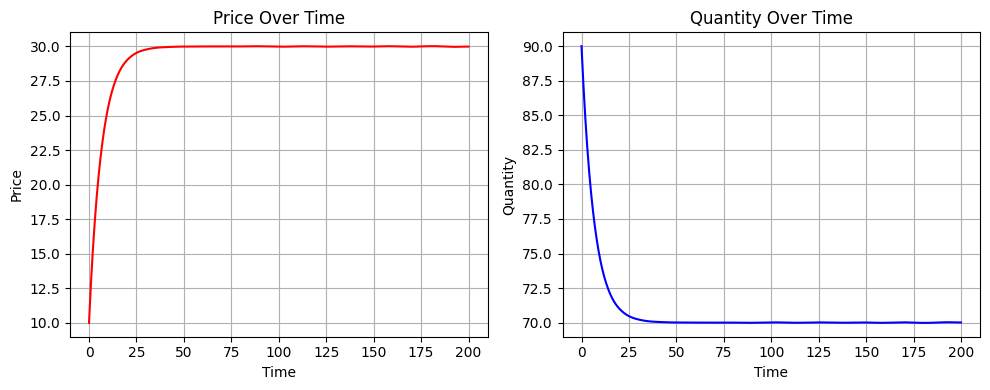

In [82]:

def price_dynamics(t, P, A, b, C, d, eta):
    """
    Continuous-time price adjustment equation:
        dP/dt = eta * (Demand(P) - Supply(P))

    Where Demand(P) = A - b * P
          Supply(P) = C + d * P
    """
    price = P[0]  # ODE integrators expect y as an array, so we take P[0]
    
    # Demand and supply given current price
    D = A - b * price
    S = C + d * price
    
    # Price changes proportional to excess demand
    dP_dt = eta * (D - S)
    return [dP_dt]

# -----------------------------------------------------------------------
# Parameters for Demand and Supply curves
# -----------------------------------------------------------------------
A = 100.0   # Intercept for Demand
b = 1.0     # Slope for Demand (negative slope => b>0 in A - b*P)
C = 10.0    # Intercept for Supply
d = 2.0     # Slope for Supply
eta = 0.05  # Speed of price adjustment

# Initial price
P0 = [10.0]

# Time span for simulation
t_span = (0, 200)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the ODE for Price over time
sol = solve_ivp(
    fun=price_dynamics,
    t_span=t_span,
    y0=P0,
    t_eval=t_eval,
    args=(A, b, C, d, eta)
)

# Extract the price as a function of time
P_vals = sol.y[0]

# Compute the market-clearing Quantity at each time
# Q(t) = Demand(P(t)) = Supply(P(t))
Q_vals = A - b * P_vals  # same as C + d * P_vals if the system is consistent

# -----------------------------------------------------------------------
# Plot: Quantity vs. Price (parametric plot)
# -----------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(Q_vals, P_vals, 'b-', linewidth=2)
plt.title("Quantity vs. Price Dynamics (Parametric Plot)")
plt.xlabel("Quantity Q")
plt.ylabel("Price P")
plt.grid(True)

# Optional: add arrows or markers to show direction over time
# We'll place some markers along the curve
marker_indices = np.linspace(0, len(t_eval)-1, 20, dtype=int)
plt.scatter(Q_vals[marker_indices], P_vals[marker_indices], color='red', s=15)

plt.show()

# -----------------------------------------------------------------------
# (Optional) Time Series Plots
# -----------------------------------------------------------------------
plt.figure(figsize=(10,4))

# Price over time
plt.subplot(1,2,1)
plt.plot(sol.t, P_vals, 'r-', label='Price P(t)')
plt.title("Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)

# Quantity over time
plt.subplot(1,2,2)
plt.plot(sol.t, Q_vals, 'b-', label='Quantity Q(t)')
plt.title("Quantity Over Time")
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.grid(True)

plt.tight_layout()
plt.show()